In [133]:
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph
import collections
import matplotlib.pyplot as plt
import seaborn as sns

In [134]:
from cdlib import evaluation

n = 100000
tau1 = 3 # 2-3
tau2 = 1.5 # 1-2
mu = 0.1

def create_benchmark_graph(n, tau1, tau2, mu, average_degree, min_community, seed):
    G = LFR_benchmark_graph(
        n, tau1, tau2, mu, average_degree=average_degree, \
            min_community=min_community, seed=seed
    )
    return G


In [135]:
configuration = {
    'n':[10000,20000, 50000, 100000],
    'tau1': [3],
    'tau2': [1.5],
    'mu': [0.1],
    'avg_degree': [5]
}

In [136]:

configurations_possible = []

def get_possible_configs(conf, index, current):

    if index == len(conf):
        configurations_possible.append(current.copy())
        print(current)
        return 

    here = list(conf.keys())[index]

    for value in conf[here]:
        current[here] = value
        get_possible_configs(conf, index + 1, current)


get_possible_configs(configuration, 0, {})


{'n': 10000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
{'n': 50000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
{'n': 100000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}


In [137]:
from collections import defaultdict
import community.community_louvain as community_louvain
import math
from cdlib import algorithms
import cdlib

def get_communities(G):

    communities = {frozenset(G.nodes[v]["community"]) for v in G}


    # (com_nr, set community)
    lrf_dict = defaultdict()
    c = 1
    for y in communities:
        lrf_dict[c] = y
        c+= 1


    # (comm_nr, set communities)
    partion = community_louvain.best_partition(G)
    louvain_dict = defaultdict(set)





    for node, community in partion.items():
        louvain_dict[community].add(node) # (community_nr, nodes)

    x1 = cdlib.NodeClustering(list(louvain_dict.values()), G)
    x2 = cdlib.NodeClustering(list(lrf_dict.values()), G)

    print(evaluation.normalized_mutual_information(x1, x2))


    return lrf_dict, louvain_dict



def get_percentage_intercetion(set_ids, mapping_ids):

    z = set()
    for id in set_ids:
        z = z.union(mapping_ids[id])
    return z


def is_small_community(G, community):
    res_limit_val = math.sqrt(2*G.number_of_edges())
    sub = G.subgraph(community)
    return sub.number_of_edges() < res_limit_val



def compare_communities_stats(G):

    lrf_dict, louvain_dict = get_communities(G)

    assigned_ones = defaultdict(set)# sets from the louvain that are assigned as most similar to the same set of the lrf

    for k, y in lrf_dict.items():
        
        higher = -1
        target_set = set() # set with the most common nodes
        overlapping_set_nr = set()

        for nr, com_set in louvain_dict.items():

            temp = com_set & y
            
            if len(temp) > 0:
                overlapping_set_nr.add(nr)
                assigned_ones[nr].add(k)

            
            if higher < len(temp):
                higher = len(temp)

        louvain_union = get_percentage_intercetion(overlapping_set_nr, louvain_dict)
        lrf_union = lrf_dict[k]
        percentage = len(louvain_union.intersection(lrf_union)) / max(len(louvain_union), len(lrf_union))
        #print("For lrf community with size {}, there were found in louvain {} communities overlapping".format(len(y), len(overlapping_set_nr)))
        #print("For lrf community id {} (resol_lim : {}), they intersect with louvain communities ids {} => {}".format(k,\
        #is_small_community(G, lrf_union) ,overlapping_set_nr, percentage))

    THRESHOLD = 0.9
    counter = 0
    print("the other way around:")
    for k, y in assigned_ones.items(): 
        temp = []
        # k -> community id of louvain
        # y -> set of communities id of lrf
        # community id of louvain -> communties of lrf that overlap with the louvain
        louvain_union = louvain_dict[k]
        lrf_union = get_percentage_intercetion(y, lrf_dict)
        percentage = len(louvain_union.intersection(lrf_union)) / max(len(louvain_union), len(lrf_union))
        #print("{} (louvain (resol_lim : {})) : {} (lrf) => {}" .format(k, is_small_community(G, louvain_union), y, percentage))

        for v in y:
            if len(lrf_dict[v] & louvain_union) / len(lrf_dict[v]) >= THRESHOLD:
                temp.append(v)
        
        if len(temp) > 1:
            #print(k, "=>", len(temp))
            counter += len(temp) - 1
            #print(v, len(lrf_dict[v] & louvain_union) / len(lrf_dict[v]) )

    print("counter total", counter, "|", len(lrf_dict), "|", counter/ len(lrf_dict))

def compare_communities_number(G):
    partion = community_louvain.best_partition(G)
    l_c = max(partion.values())

    communities = {frozenset(G.nodes[v]["community"]) for v in G}
    lrf_c = len(communities)

    return l_c , lrf_c

algorithms.louvain(nx.karate_club_graph())

In [138]:
def community_size_distribution(G):
    lrf_dict, louvain_dict = get_communities(G)
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
    fig.suptitle('Internal degree of communities distribution')
    res_limit_val = math.sqrt(2*G.number_of_edges())
    counter=collections.Counter([G.subgraph(x).number_of_edges() for x in lrf_dict.values()])
    counter2=collections.Counter([G.subgraph(x).number_of_edges() for x in louvain_dict.values()])
    ax1.hist(counter,bins=20)
    ax2.hist(counter2,bins=20)
    ax1.axvline(x=res_limit_val, color= 'r')
    ax2.axvline(x=res_limit_val, color= 'r')
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set(title='Real Communities', ylabel='Frequency',xlabel='Internal degree')
    ax2.set(title='Louvain Communities', ylabel='Frequency',xlabel='Internal degree')

In [139]:
def run_experiment(configurations_possible, experiment_call_back):

    values = []
    for configuration in configurations_possible:
        print(configuration)
        G = create_benchmark_graph(configuration['n'], configuration['tau1'], \
            configuration['tau2'], configuration['mu'], \
            average_degree=configuration['avg_degree'], min_community=20, seed=10)
        values.append(experiment_call_back(G))
        #print(values)
    
    #print(values)
    return values

In [140]:
run_experiment(configurations_possible, compare_communities_number)

{'n': 10000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
{'n': 50000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
{'n': 100000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}


[(118, 183), (152, 328), (259, 678), (331, 951)]

In [141]:
run_experiment(configurations_possible, compare_communities_stats)

{'n': 10000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
MatchingResult(score=0.930788694288894, std=None)
the other way around:
counter total 84 | 183 | 0.45901639344262296
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
MatchingResult(score=0.9166295646270735, std=None)
the other way around:
counter total 193 | 328 | 0.5884146341463414
{'n': 50000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
MatchingResult(score=0.9060603507956274, std=None)
the other way around:
counter total 466 | 678 | 0.6873156342182891
{'n': 100000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
MatchingResult(score=0.903771311986476, std=None)
the other way around:
counter total 695 | 951 | 0.7308096740273397


[None, None, None, None]

{'n': 10000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
MatchingResult(score=0.9260984611464887, std=None)
{'n': 20000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
MatchingResult(score=0.9193665199735749, std=None)
{'n': 50000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
MatchingResult(score=0.9031583622904974, std=None)
{'n': 100000, 'tau1': 3, 'tau2': 1.5, 'mu': 0.1, 'avg_degree': 5}
MatchingResult(score=0.9051022403792195, std=None)


[None, None, None, None]

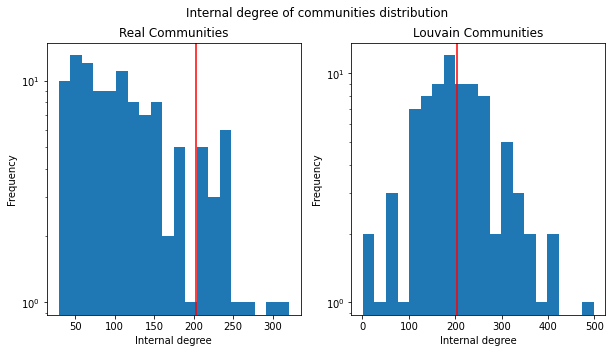

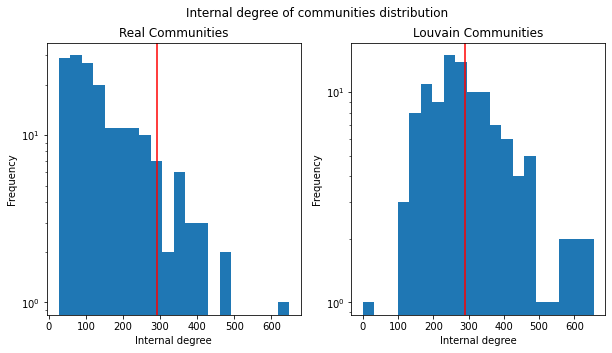

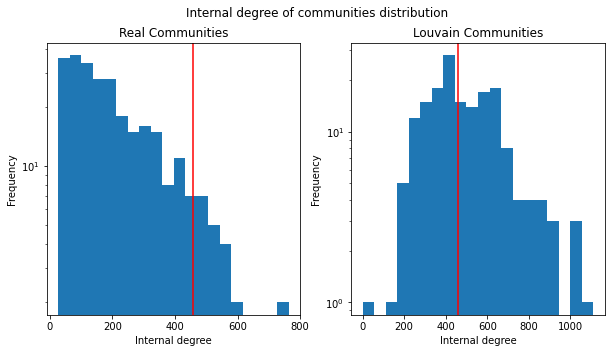

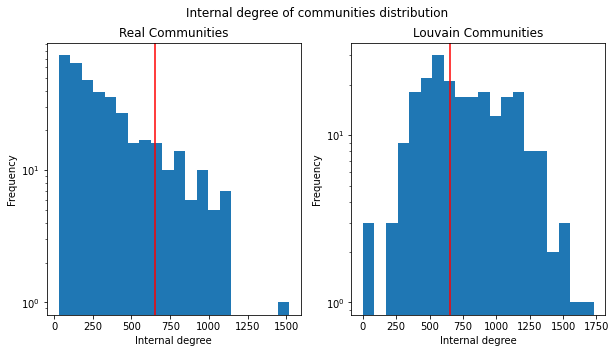

In [142]:
run_experiment(configurations_possible, community_size_distribution)
